Імпорт бібліотек , завантаження моделі та створення функції зчитування Wav файлів.

In [36]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import scipy.signal
import soundfile as sf
from IPython.display import Audio, display


In [37]:
#Імпортуємо YAMNet модель
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [38]:
#зчитування WAV файлів та переведення його в зручну модель
def load_wav_16k_mono(filename):
    """Завантажити WAV-файл, перевести в моно та 16 кГц."""
    wav, sample_rate = sf.read(filename)
    if wav.ndim > 1:
        wav = np.mean(wav, axis=1)
    if sample_rate != 16000:
        num_samples = int(len(wav) * 16000 / sample_rate)
        wav = scipy.signal.resample(wav, num_samples)
    return tf.convert_to_tensor(wav, dtype=tf.float32)

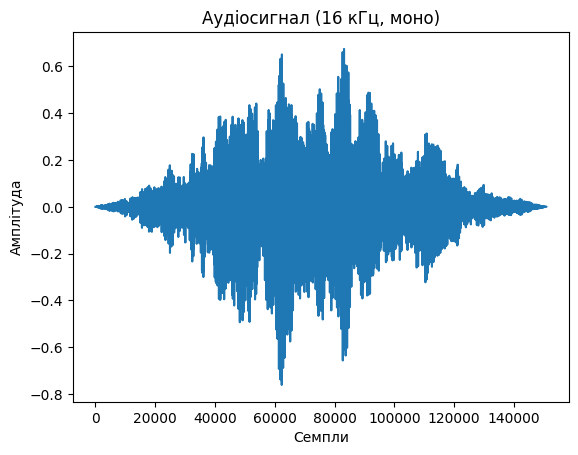

In [62]:
#Шлях до тестового файлу
filename = "D:/YAMNet1/data/sample.wav"

# Завантаження даних
testing_wav_data = load_wav_16k_mono(filename)

# Візуалізація сигналу
plt.plot(testing_wav_data.numpy())
plt.title("Аудіосигнал (16 кГц, моно)")
plt.xlabel("Семпли")
plt.ylabel("Амплітуда")
plt.show()

# Програвання аудіо
display(Audio(data=testing_wav_data.numpy(), rate=16000))

In [40]:
#Список класів у моделі
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


In [41]:
#Перевіряємо тестовий звук
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Vehicle
The embeddings shape: (31, 1024)


Модель правильно визначила, що звук видала техніка. Тепер перейдемо до другого кроку, витягнемо ембедінги з нашого аудіо.

In [42]:
#Завантажуємо датасет з потрібними нам даними.
DATA_DIR = {
    "motorcycle": "D:\YAMNet1\data\motorcycle",
    "background": "D:\YAMNet1\data\background"
}
print(DATA_DIR)

{'motorcycle': 'D:\\YAMNet1\\data\\motorcycle', 'background': 'D:\\YAMNet1\\data\x08ackground'}


<>:3: SyntaxWarning: invalid escape sequence '\Y'
<>:4: SyntaxWarning: invalid escape sequence '\Y'
<>:3: SyntaxWarning: invalid escape sequence '\Y'
<>:4: SyntaxWarning: invalid escape sequence '\Y'
C:\Users\Admin\AppData\Local\Temp\ipykernel_8720\3636487337.py:3: SyntaxWarning: invalid escape sequence '\Y'
  "motorcycle": "D:\YAMNet1\data\motorcycle",
C:\Users\Admin\AppData\Local\Temp\ipykernel_8720\3636487337.py:4: SyntaxWarning: invalid escape sequence '\Y'
  "background": "D:\YAMNet1\data\background"


In [43]:
# Функція для отримання ембеддінгів з сегментованих аудіофайлів
def extract_embeddings_segmented(base_dir, yamnet_model, max_files_per_class=None, segment_duration=0.96, target_rate=16000):
    dataset = []
    class_map = {
        "motorcycle": 1,
        "background": 0
    }
    samples_per_segment = int(segment_duration * target_rate)

    for class_name, label in class_map.items():
        folder_path = os.path.join(base_dir, class_name)
        wav_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
        if max_files_per_class:
            wav_files = wav_files[:max_files_per_class]

        for fname in wav_files:
            file_path = os.path.join(folder_path, fname)
            try:
                wav = load_wav_16k_mono(file_path).numpy()
                total_samples = len(wav)

                # Розбиваємо на фрагменти по 0.96 с
                for start in range(0, total_samples - samples_per_segment + 1, samples_per_segment):
                    segment = wav[start:start + samples_per_segment]
                    segment_tensor = tf.convert_to_tensor(segment, dtype=tf.float32)
                    _, embeddings, _ = yamnet_model(segment_tensor)
                    mean_embedding = tf.reduce_mean(embeddings, axis=0)
                    dataset.append((mean_embedding.numpy(), label))

            except Exception as e:
                print(f"Помилка з {file_path}: {e}")

    return dataset



In [44]:
dataset = extract_embeddings_segmented("D:/YAMNet1/data", yamnet_model)  


# Розділимо features і labels
X = np.array([x for x, _ in dataset])
y = np.array([y for _, y in dataset])

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (5121, 1024)
y shape: (5121,)


Знайдемо найкращий класифікатор.

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_models(X, y, test_size=0.2, random_state=42):
    # Розділення
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Список моделей
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "SVM (RBF)": SVC(probability=True),
        "KNN": KNeighborsClassifier(),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42)
    }

    # Збір результатів
    results = []
    plt.figure(figsize=(8, 6))

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        # Зберігаємо результати
        results.append({
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1 Score": f1,
            "AUC": roc_auc
        })

        # Побудова ROC-кривої
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    # Завершення графіка
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for All Models")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Таблиця результатів
    results_df = pd.DataFrame(results)
    return results_df.sort_values(by="AUC", ascending=False)


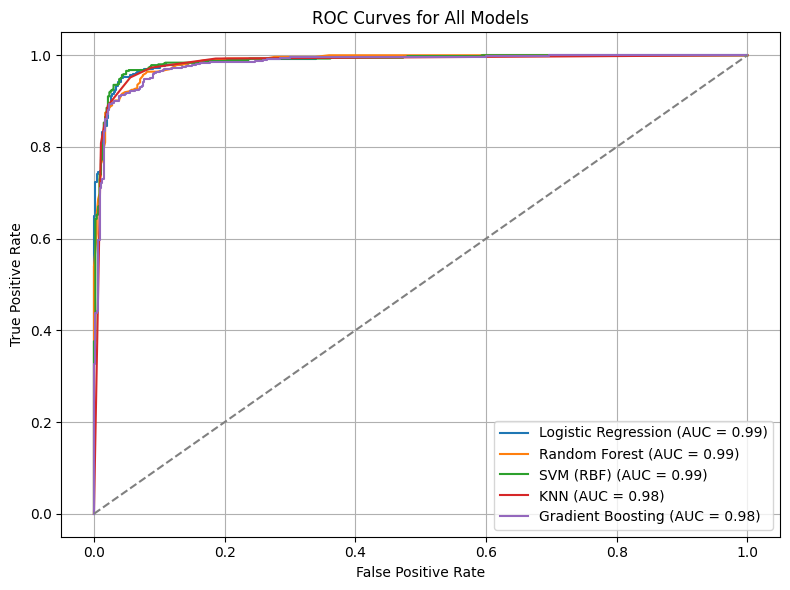

                 Model  Accuracy  Precision    Recall  F1 Score       AUC
0  Logistic Regression  0.953171   0.965328  0.948029  0.956600  0.987996
2            SVM (RBF)  0.954146   0.965392  0.949821  0.957543  0.987273
1        Random Forest  0.932683   0.950276  0.924731  0.937330  0.986323
3                  KNN  0.948293   0.953321  0.951613  0.952466  0.983504
4    Gradient Boosting  0.928780   0.943327  0.924731  0.933937  0.982113


In [46]:
results_df = evaluate_models(X, y)
print(results_df)

Згідно статистики, найкращими класифікаторами для нашого датасету є лінійна регресія, та SVM, використаємо логічну регресію.

=== Logistic Regression Evaluation ===
Accuracy: 0.953170731707317
Precision: 0.9653284671532847
Recall: 0.9480286738351255
F1 Score: 0.9566003616636528
Confusion Matrix:
 [[448  19]
 [ 29 529]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       467
           1       0.97      0.95      0.96       558

    accuracy                           0.95      1025
   macro avg       0.95      0.95      0.95      1025
weighted avg       0.95      0.95      0.95      1025



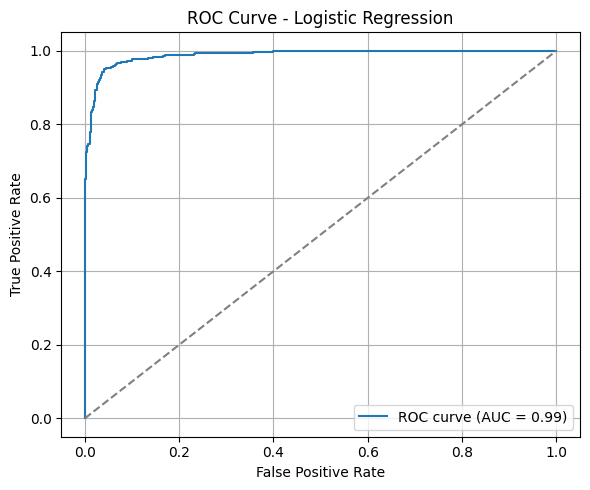

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt

# Розділення датасету
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Логістична регресія
clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train, y_train)
y_pred = clf_lr.predict(X_test)
y_proba = clf_lr.predict_proba(X_test)[:, 1]  # Для ROC

# Метрики
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Виведення
print("=== Logistic Regression Evaluation ===")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ROC-крива
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


Можемо потестувати роботу на кастомних аудіофайлах.

In [56]:
from collections import Counter
import numpy as np
def predict_sound_segmented(file_path, yamnet_model, clf_model, class_names={0: "background", 1: "motorcycle"}):
    try:
        # Завантажити та обробити аудіо
        wav = load_wav_16k_mono(file_path).numpy()
        segment_duration = 0.96
        sample_rate = 16000
        samples_per_segment = int(segment_duration * sample_rate)

        predictions = []
        probabilities = []

        total_samples = len(wav)
        num_segments = 0

        print(f"\nАналіз звуку: {file_path}")
        print(f"Розбивка на фрагменти по {segment_duration:.2f} секунд:")

        for start in range(0, total_samples - samples_per_segment + 1, samples_per_segment):
            segment = wav[start:start + samples_per_segment]
            segment_tensor = tf.convert_to_tensor(segment, dtype=tf.float32)
            _, embeddings, _ = yamnet_model(segment_tensor)
            mean_embedding = tf.reduce_mean(embeddings, axis=0).numpy().reshape(1, -1)

            pred_class = clf_model.predict(mean_embedding)[0]
            prob = clf_model.predict_proba(mean_embedding)[0][pred_class]

            predictions.append(pred_class)
            probabilities.append(prob)
            num_segments += 1

            print(f"   Фрагмент {num_segments}: {class_names[pred_class]} (ймовірність: {prob:.2f})")

        # Аналіз загального результату
        if predictions:
            most_common_class = Counter(predictions).most_common(1)[0][0]
            avg_prob = np.mean(probabilities)
            print("\n Середній висновок:")
            print(f"  Клас: {class_names[most_common_class]}")
            print(f"  Середня ймовірність: {avg_prob:.2f}")
        else:
            print(" Недостатньо даних для аналізу.")

    except Exception as e:
        print(f" Помилка при обробці {file_path}: {e}")



In [49]:
new_file = "D:/YAMNet1/data/sample.wav"

In [63]:
predict_sound_segmented(new_file, yamnet_model, clf_lr)


Аналіз звуку: D:/YAMNet1/data/sample.wav
Розбивка на фрагменти по 0.96 секунд:
   Фрагмент 1: background (ймовірність: 0.61)
   Фрагмент 2: motorcycle (ймовірність: 0.52)
   Фрагмент 3: motorcycle (ймовірність: 1.00)
   Фрагмент 4: motorcycle (ймовірність: 1.00)
   Фрагмент 5: motorcycle (ймовірність: 0.99)
   Фрагмент 6: motorcycle (ймовірність: 0.96)
   Фрагмент 7: motorcycle (ймовірність: 0.98)
   Фрагмент 8: motorcycle (ймовірність: 0.92)
   Фрагмент 9: motorcycle (ймовірність: 0.61)

 Середній висновок:
  Клас: motorcycle
  Середня ймовірність: 0.84


Тепер додамо функцію введення данних з мікрофону, для тестування звуків в реальному часі.

In [60]:
import sounddevice as sd
import queue
import numpy as np
import tensorflow as tf
import time

def predict_realtime_from_microphone(
    yamnet_model,
    clf_model,
    class_names={0: "background", 1: "motorcycle"},
    segment_duration=0.96
):
    sample_rate = 16000
    segment_samples = int(segment_duration * sample_rate)

    q = queue.Queue()

    def audio_callback(indata, frames, time_info, status):
        if status:
            print(f"⚠️ {status}")
        q.put(indata.copy())

    print(" CTRL+C to stop)")

    try:
        with sd.InputStream(
            samplerate=sample_rate,
            channels=1,
            dtype='float32',
            blocksize=segment_samples,
            callback=audio_callback
        ):
            while True:
                audio_chunk = q.get()
                wav = np.squeeze(audio_chunk)
                if wav.ndim != 1:
                    wav = wav[:, 0]

                # Tensor для YAMNet
                segment_tensor = tf.convert_to_tensor(wav, dtype=tf.float32)

                # Отримати ембедінги
                _, embeddings, _ = yamnet_model(segment_tensor)
                mean_embedding = tf.reduce_mean(embeddings, axis=0).numpy().reshape(1, -1)

                # Передбачення
                pred_class = clf_model.predict(mean_embedding)[0]
                prob = clf_model.predict_proba(mean_embedding)[0][pred_class]

                print(f" {class_names[pred_class]} (ймовірність: {prob:.2f})")

    except KeyboardInterrupt:
        print("\nЗупинено користувачем.")



In [ ]:
predict_realtime_from_microphone(yamnet_model, clf_lr)
# Тестування по мікрофону.


 CTRL+C to stop)
 motorcycle (ймовірність: 1.00)
 background (ймовірність: 0.89)
 background (ймовірність: 0.93)
 motorcycle (ймовірність: 0.73)
 motorcycle (ймовірність: 0.99)
 background (ймовірність: 0.93)
 background (ймовірність: 0.94)
 motorcycle (ймовірність: 1.00)
 motorcycle (ймовірність: 0.98)
 motorcycle (ймовірність: 0.97)
 motorcycle (ймовірність: 0.90)
 motorcycle (ймовірність: 0.92)
 motorcycle (ймовірність: 0.99)
 motorcycle (ймовірність: 0.95)
 motorcycle (ймовірність: 0.85)
 motorcycle (ймовірність: 1.00)
 motorcycle (ймовірність: 0.98)
 motorcycle (ймовірність: 1.00)
 motorcycle (ймовірність: 1.00)
 motorcycle (ймовірність: 1.00)
 motorcycle (ймовірність: 0.95)
 motorcycle (ймовірність: 0.84)
 motorcycle (ймовірність: 0.96)
 motorcycle (ймовірність: 0.82)
 background (ймовірність: 0.74)
 background (ймовірність: 0.55)
 background (ймовірність: 0.99)
 background (ймовірність: 0.99)
 motorcycle (ймовірність: 0.96)
 motorcycle (ймовірність: 0.94)
 motorcycle (ймовірніст